Credit to https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import itertools

from keras.utils.np_utils import to_categorical
from keras.layers import Lambda, Dense, Dropout, Flatten, Conv2D, MaxPool2D,BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import  Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Set the random seed
random_seed = 42
np.random.seed(random_seed)
%matplotlib inline

# Data Preparation
## Load the data

In [73]:
train = pd.read_csv("input/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
test= pd.read_csv("input/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

## Sanity check and inspect

In [76]:
# Check the data
X_train.isnull().any().describe()
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

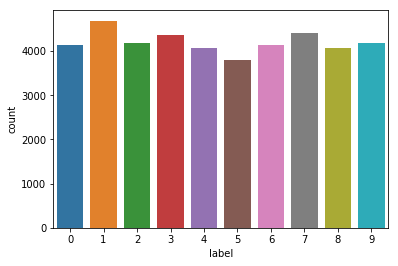

In [77]:
g = sns.countplot(Y_train)

In [78]:
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

## Reshape as image

In [79]:
# reshape the data for kreas image format
X_train = X_train.values.reshape(-1,28,28,1)
X_train.shape
test = test.values.reshape(-1,28,28,1)
test.shape

(28000, 28, 28, 1)

## Normalize

In [80]:
# normalization
X_train = X_train/255.0
test = test/255.0

## Label encoding

In [81]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

## Split training and valdiation set

In [82]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

## Example data points

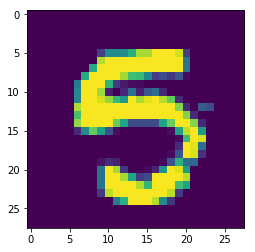

In [83]:
g = plt.imshow(X_train[1][:,:,0])

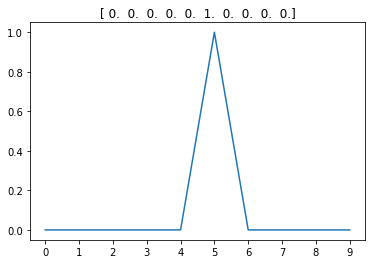

In [84]:
plt.title(Y_train[1])
plt.plot(Y_train[1])
plt.xticks(range(10));

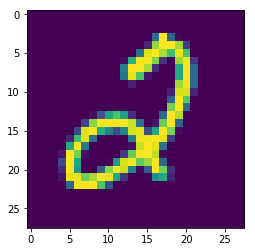

In [85]:
g = plt.imshow(X_train[3][:,:,0])

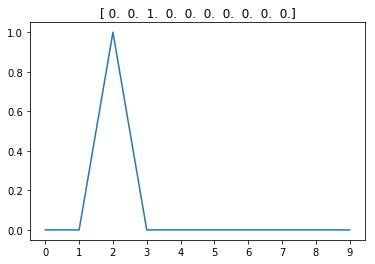

In [86]:
plt.title(Y_train[3])
plt.plot(Y_train[3])
plt.xticks(range(10));

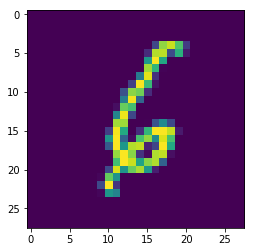

In [87]:
g = plt.imshow(X_train[6][:,:,0])

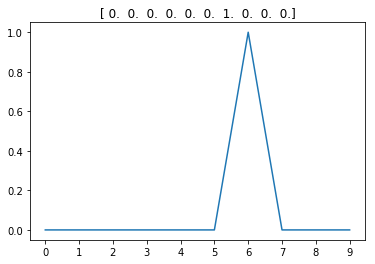

In [88]:
plt.title(Y_train[6])
plt.plot(Y_train[6])
plt.xticks(range(10));

# CNN

## Augmenting the image data

In [99]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        shear_range = 0.15, # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
)

datagen.fit(X_train)

## Construct the model

In [90]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
model= Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
print(model.input_shape)
print(model.output_shape)

(None, 28, 28, 1)
(None, 10)


## Set the optimizer and annealer

In [91]:
lr = 0.001
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [92]:
model.compile(
    optimizer=RMSprop(lr=lr, rho=0.9, epsilon=1e-08, decay=0.0),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Fit the model

In [100]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
#0.9814

Epoch 1/1
 - 318s - loss: 0.2207 - acc: 0.9342 - val_loss: 0.0638 - val_acc: 0.9793


# TensorFlow Version

In [ ]:
def conv(x, shape):
    weight_variable = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    bias_variable   = tf.Variable(tf.constant(0.1, shape=[shape[-1]]))
    conv2d          = tf.nn.conv2d(x, weight_variable, strides=[1,1,1,1], padding='SAME')
    return tf.nn.relu(conv2d + bias_variable)

def compute_cost(Z3, Y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def get_batch(step):
    left = step*100
    right = step*100 + 100
    X_batch = X_train[left:right]
    Y_batch = Y_train[left:right]
    return X_batch, Y_batch

def get_test(step):
    left = step*100
    right = step*100 + 100
    batch = test[left:right]
    return batch

def last_10():
    batch = X_test[15600:15610]
    return batch

def fc_layer(x, shape):
    weight_variable = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    bias_variable   = tf.Variable(tf.constant(0.1, shape=[shape[-1]]))
    flat = tf.reshape(x, [-1, shape[0]])
    return  tf.nn.relu(tf.matmul(flat, weight_variable) + bias_variable)

In [ ]:
import os
import warnings
from tensorflow.python.framework import ops
from os.path import split
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.7
from numpy import argmax

# conv layer-1
x_image = tf.placeholder(tf.float32, [None, 28, 28, 1]) # [batch, in_height, in_width, in_channels]

conv_1 = conv(x_image, [5, 5, 1, 32]) # [filter_height, filter_width, in_channels, out_channels]
pool_1 = max_pool_2x2(conv_1)

# conv layer-2
conv_2 = conv(pool_1, [5, 5, 32, 64])
pool_2 = max_pool_2x2(conv_2)

# # full connection
h_fc1 = fc_layer(pool_2, [7 * 7 * 64, 1024])

# dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# output layer: softmax
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape= [10]))

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
y_ = tf.placeholder(tf.float32, [None, 10])

# model training
cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))
train_step = tf.train.AdamOptimizer(0.000001).minimize(cross_entropy)

correct_prediction = tf.equal(tf.arg_max(y_conv, 1), tf.arg_max(y_, 1))

cost = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv)))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

costs = [] 


with tf.Session(config=config) as sess:
    sess.run(tf.initialize_all_variables())
    for epoch in range(5000):
        STEP = 420
        for i in range(STEP):
            X_batch, Y_batch = get_batch(i)
            train_step.run(feed_dict = {x_image: X_batch, y_: Y_batch, keep_prob: 0.5})
            cost = cross_entropy.eval(feed_dict={x_image: X_batch, y_: Y_batch, keep_prob: 1.0})/100
        if epoch % 1 == 0:
            print("cost after epoch %i: %f" % (epoch, cost))
            train_accuracy = accuracy.eval(feed_dict={x_image: X_batch, y_: Y_batch, keep_prob: 1.0})
            print("training accuracy %g"%(train_accuracy))
        if epoch % 1 == 0:
            costs.append(cost)
        if cost <= 0.0015:
            break
    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel("learning rate =" + str(0.001))
    plt.show()

    with open("sub.csv", "w") as f:
        step = 280
        with warnings.catch_warnings():
            f.write("ImageId,Label\n")
            warnings.filterwarnings("ignore",category=DeprecationWarning)
            index = 0
            for s in range(step):
                logits = sess.run(y_conv, feed_dict={x_image: get_test(s), keep_prob: 1.0})
                for i in range(100):
                    z3 = logits[i]
                    predicted_tags = argmax(z3)
                    f.write("%s,%s\n" %(i+100*s +1,  predicted_tags))
        print("done")

# Evaluate the model
## Training and validation curves

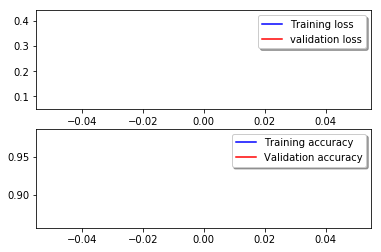

In [94]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion matrix

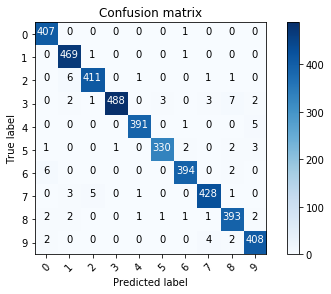

In [95]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## most important errors

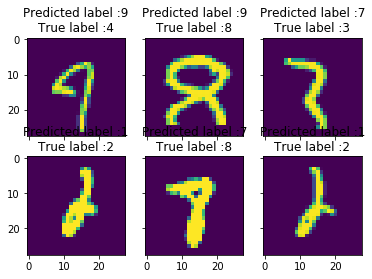

In [96]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)